# Self-Organising Maps - Countries

In [2]:
# from __future__ import division

import numpy as np
import pandas as pd
import math
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import cm

%matplotlib inline

#### Dataset for training

In [3]:
data = pd.read_csv('Countries2010.csv')
data.head()

,CountryName,"Adolescent fertility rate (births per 1,000 women ages 15-19)",GDP per capita (current US$),GNI (current US$),"Incidence of tuberculosis (per 100,000 people)",Improved water source (% of population with access),"Mortality rate, neonatal (per 1,000 live births)","Mortality rate, under-5 (per 1,000)","Mortality rate, infant (per 1,000 live births)","Population, ages 0-14 (% of total)",Population ages 65 and above (% of total),"Tuberculosis case detection rate (%, all forms)",Urban population (% of total),Rural population (% of total population),Mobile cellular subscriptions (per 100 people),Internet users (per 100 people),"GNI per capita, PPP (current international $)","Inflation, GDP deflator (annual %)"
0,Afghanistan,99.6324,569.940729,1.599880e+10,189.0,48.0,38.7,105.0,75.1,47.589344,2.275250,53.0,24.689,75.311,45.778175,4.0,1640.0,9.437795
1,Albania,19.9188,4094.358832,1.180780e+10,17.0,95.6,7.5,16.6,14.8,21.425123,10.954818,88.0,52.163,47.837,85.468247,45.0,9200.0,4.489981
2,Algeria,10.7334,4473.486446,1.609964e+11,87.0,85.7,16.5,27.3,23.5,27.191308,5.550988,71.0,67.526,32.474,88.444875,12.5,12630.0,16.119787
3,Antigua and Barbuda,51.7550,13017.310388,1.104050e+09,5.8,97.9,6.0,9.9,7.7,26.233192,7.233501,140.0,26.239,73.761,192.553277,47.0,19590.0,1.366002
4,Armenia,26.5732,3124.784018,9.718566e+09,63.0,98.4,9.5,18.0,16.1,20.514959,10.547745,76.0,63.580,36.420,130.432233,25.0,6690.0,7.768715


## SOM Setup

In [4]:
data.shape

(171, 18)

In [5]:
map_side = 5
period = 10000
learning_rate = 0.15
normalize = True

We need to drop the 'Country Name' field, as it cannot be processed by the network in a conventional manner. It should be irrelevant for the network.

In [6]:
countries_names = data['CountryName']
data = data.drop(['CountryName'], axis=1)

num_inputs = data.shape[1]
num_data = data.shape[0]

columns = data.columns
neighbour = map_side / 2

if normalize:
    data = (data - data.min()) / (data.max() - data.min())
data = data.to_numpy()
# Create the weight matrix.
weight_matrix = np.random.random((map_side, map_side, num_inputs))


#### Auxiliary functions for training/classifying

In [7]:

def get_bmu(input_pattern, w_matrix, m):
    minimum_distance = math.inf
    for pos_x, row in enumerate(w_matrix):
        for pos_y, weight in enumerate(row):
            current_result = euclid_distance(input_pattern, weight, False)
            if current_result < minimum_distance:
                minimum_distance = current_result
                bmu = weight
                bmu_idx = np.array([pos_x, pos_y])
    return (bmu, bmu_idx)

def euclid_distance(matrix_a, matrix_b, include_sqrt):
    if include_sqrt:
        return np.sqrt(np.sum((matrix_a - matrix_b)**2))
    return np.sum((matrix_a - matrix_b)**2)
        

In [8]:
def learning_rate_variation(lr_initial, i, iter_number):
    learning_rate = lr_initial * (1 - (i / iter_number))
    return learning_rate


In [9]:
def neighbour_variation(current_neigbourhood, i, iter_number):
    new_neighbourhood = 1 + current_neigbourhood * (1 - (i / iter_number))
    return new_neighbourhood

In [10]:
def decay(bmu_distance, current_neighbour):
    return np.exp(-bmu_distance**2 / (2*current_neighbour**2))

#### Funciones para dibujar la salida de la red

In [34]:
def draw_map(value_matrix, iteration, objective):
    fig = plt.figure()
    caracteristics = {
        'GDP_PER_CAPITA': 1,
        'MORTALITY_RATE': 5
    }
    caracteristic = caracteristics[objective]
    
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, value_matrix.shape[0]+1))
    ax.set_ylim((0, value_matrix.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iterationes' % iteration)

    for x in range(1, value_matrix.shape[0] + 1):
        for y in range(1, value_matrix.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=[0, value_matrix[x-1,y-1,caracteristic], 0],
                         edgecolor='none'))
    plt.show()

def hist_3d(activation_map):
    array_data = np.array(activation_map)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    data_x, data_y = np.meshgrid(
            np.arange(array_data.shape[1]),
            np.arange(array_data.shape[0])
    )
    cmap = cm.get_cmap('jet')
    data_x = data_x.flatten()
    data_y = data_y.flatten()
    data_z = array_data.flatten()
    rgba = [cmap(k/max(data_z)) for k in data_z] 
    ax.bar3d( data_x,
              data_y,
              np.zeros(len(data_z)),
              0.5, 0.5, data_z,
            color=rgba)
    plt.show()

### Model metrics
Here we have functions that will show us if our network is working properly.

In [12]:
def adyacent_error(input_pattern, w_matrix):
    minimum_distance = math.inf
    minimum_distance2 = math.inf
    bmu_id1 = np.array([0, 0])
    for pos_x, row in enumerate(w_matrix):
        for pos_y, weight in enumerate(row):
            current_result = euclid_distance(input_pattern, weight, False)
            if current_result < minimum_distance:
                bmu_id2 = bmu_id1
                minimum_distance2 = minimum_distance

                minimum_distance = current_result
                bmu_id1 = np.array([pos_x, pos_y])
            elif current_result < minimum_distance2:
                bmu_id2 = np.array([pos_x, pos_y])
                minimum_distance2 = current_result
    is_adyacent = not(abs(bmu_id1[0] - bmu_id2[0]) <= 1 and abs(bmu_id1[1] - bmu_id2[1]) <=1)
    return is_adyacent

def total_topological_error(ex_data, w_matrix):
    sol=0
    for data in ex_data :
        sol += adyacent_error(data, w_matrix)
    sol = sol/len(ex_data)
    return sol



In [13]:

def quant_error(weight_matrix, test_data):
    res = 0
    for e in test_data:
        bmu,_ = get_bmu(e, weight_matrix, 3)
        distancia = euclid_distance(bmu, e, True)
        res += distancia
    return res / len(test_data)

In [14]:
def activation_map(weight_matrix, test_data):
    #TODO: Clean this
    sol = [
        [
            [] for i in range(map_side)
        ] 
        for i in range(map_side)
    ]
    for index,row in test_data.iterrows():
        name = index
        data = row.to_numpy()
        bmu,idx = get_bmu(row, weight_matrix, 3)
        sol[idx[0]][idx[1]].append(name)
    return sol



In [15]:
def class_number(mapa):
    numero_clases = 0
    matriz_numero_clases = np.zeros((mapa.shape[0], mapa.shape[1]))
    for row in range(len(mapa)):
        for col in range(len(mapa[row])):
            if len(mapa[row][col]):
                numero_clases += 1
            matriz_numero_clases[row, col] = len(mapa[row][col])
    return (numero_clases, matriz_numero_clases)

In [16]:

def mapa_distancas(weight_matrix, data_ent, m):
    sol = np.zeros((m, m))
    for data in data_ent:
        bmu,idx = get_bmu(data, weight_matrix, 3)
        bmu_distance = euclid_distance(data, bmu, True)
        sol[idx[0], idx[1]] += bmu_distance
    act_map = activation_map(weight_matrix, pd.DataFrame(data_ent))
    x = 0
    y= 0
    aux=sol
    for y in range(m) :
        for x in range(m):
            if not act_map[x][y]:
                sol[x][y]=0
            else:
                sol[x][y] = sol[x][y]/act_map[x][y]
    return aux
    
    

In [17]:
def evaluate_model(weight_matrix):
    quant = quant_error(weight_matrix,data)
    top_error = total_topological_error(data,weight_matrix)
    print(f"""
        Caracteristicas:
            Learning-rate: {learning_rate}
            Period: {period}
            Numero de neurons: {map_side * map_side}
        Resultados:
            Error de cuantificacion: {quant}
            Error topologico: {top_error}
    """)


## SOM Entrenamiento

In [28]:
for i in range(period):
    index = np.random.choice(data.shape[1], 1, replace=False)  
    pattern = data[index][0]
    current_neighbour = neighbour_variation(neighbour, i, period)
    bmu, pos_bmu = get_bmu(pattern, weight_matrix, 3)
    for idx_row, row in enumerate(weight_matrix):
        for idx_col, weight in enumerate(row):
            bmu_distance = euclid_distance([idx_row, idx_col], pos_bmu, True)
            if bmu_distance < current_neighbour:
                weight_matrix[idx_row, idx_col] = weight + learning_rate_variation(learning_rate, i, period) * decay(bmu_distance, current_neighbour) * (pattern - weight)


In [29]:
evaluate_model(weight_matrix)



        Caracteristicas:
            Learning-rate: 0.15
            Period: 10000
            Numero de neurons: 25
        Resultados:
            Error de cuantificacion: 0.4052110350755841
            Error topologico: 0.017543859649122806
    


## Map and histogram

We now add the names of the countries.

In [32]:
data = pd.DataFrame(data, index=countries_names, columns=columns)

We can noe compare the adctivation of GDP per capita and mortality rate

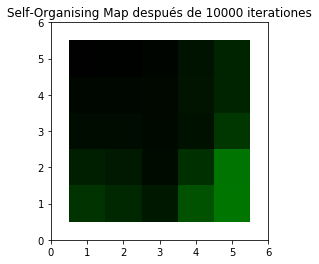

In [35]:
draw_map(weight_matrix, period, 'GDP_PER_CAPITA')

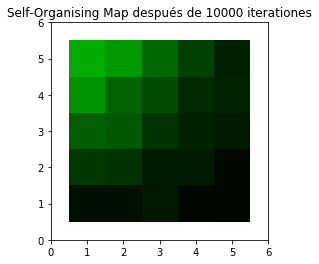

In [36]:
draw_map(weight_matrix, period, 'MORTALITY_RATE')

As expected, countries with high GDP tend to have a lower mortality rate

In [37]:
act_map = activation_map(weight_matrix, data)
act_map

[[['Bahrain',
   'Kuwait',
   'Oman',
   'Qatar',
   'Saudi Arabia',
   'United Arab Emirates'],
  ['Malaysia', 'Venezuela, RB'],
  ['Azerbaijan', 'Dominican Republic', 'Morocco', 'West Bank and Gaza'],
  ['Congo, Rep.', 'Gambia, The', 'Ghana'],
  ['Afghanistan',
   'Benin',
   'Burkina Faso',
   'Cameroon',
   'Central African Republic',
   'Chad',
   'Congo, Dem. Rep.',
   "Cote d'Ivoire",
   'Equatorial Guinea',
   'Ethiopia',
   'Guinea',
   'Guinea-Bissau',
   'Haiti',
   'Lao PDR',
   'Liberia',
   'Madagascar',
   'Malawi',
   'Mali',
   'Mauritania',
   'Mozambique',
   'Niger',
   'Nigeria',
   'Papua New Guinea',
   'Sierra Leone',
   'Sudan',
   'Tanzania',
   'Togo',
   'Uganda',
   'Yemen, Rep.',
   'Zambia']],
 [['Bahamas, The', 'Chile', 'Lebanon', 'Uruguay'],
  ['Brazil',
   'Colombia',
   'Iran, Islamic Rep.',
   'Jordan',
   'Mexico',
   'Panama',
   'Peru',
   'Tunisia',
   'Turkey'],
  ['Algeria', 'Cabo Verde', 'Ecuador', 'Gabon', 'Mongolia', 'South Africa'],
  ['Bol

We now draw each country according to their GDP

In [38]:
categorias = []
data['Categoria'] = [None for i in data.iterrows()]
iter_val = 0
for i in range(len(act_map[0])):
    for j in range(len(act_map[1])):
        for elemento in act_map[i][j]:
            data.loc[elemento, 'Categoria'] = iter_val
        iter_val += 1
data['Categoria'] = data['Categoria'].astype(int)

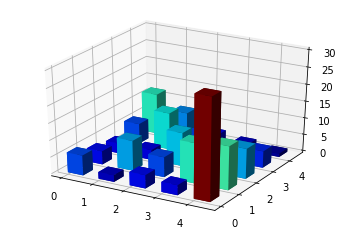

In [39]:
n_clases, act_matrix = class_number(np.array(act_map))
hist_3d(act_matrix)

In [40]:

def draw_map_countries(data, weight_matrix):
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m',
                                            category='cultural', name=shapename)
    
    aux_colors = [0, 0]
    ax = plt.axes([7, 7, 3, 3], projection=ccrs.PlateCarree())
    
    for country in shpreader.Reader(countries_shp).records():
        try:
            neuron = [int(data.loc[country.attributes['NAME_SORT']]['Categoria'] // map_side),
                      int(data.loc[country.attributes['NAME_SORT']]['Categoria'] % map_side)]
            rgb = np.array([aux_colors[0],
                            weight_matrix[neuron[0], neuron[1], 1],
                            aux_colors[1]])
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=rgb)
        except:
            try:
                neuron = [int(data.loc[country.attributes['NAME_LONG']]['Categoria'] // map_side),
                          int(data.loc[country.attributes['NAME_LONG']]['Categoria'] % map_side)]
                rgb = np.array([aux_colors[0],
                                weight_matrix[neuron[0], neuron[1], 1],
                                aux_colors[1]])
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=rgb)
            except:
                try:
                    neuron = [int(data.loc[country.attributes['NAME']]['Categoria'] // map_side),
                              int(data.loc[country.attributes['NAME']]['Categoria'] % map_side)]
                    rgb = np.array([aux_colors[0],
                                    weight_matrix[neuron[0], neuron[1], 1],
                                    aux_colors[1]])
                    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor=rgb)
                except:
                    pass
                pass
            pass
    ax.set_adjustable('datalim')
    plt.show()

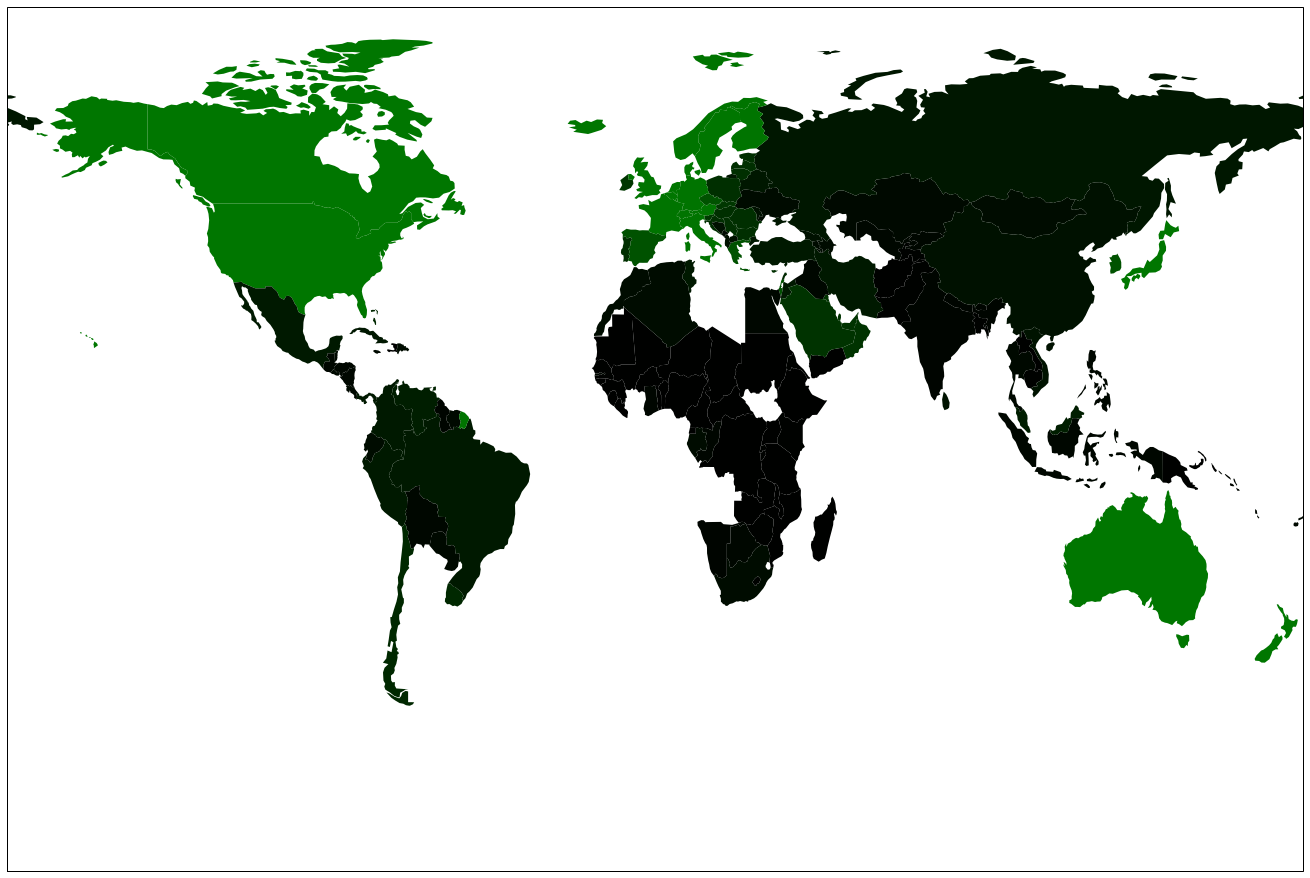

In [43]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
draw_map_countries(data, weight_matrix)